In [1]:
# --- Standard Library Imports ---
import os
import random
import warnings
import numpy as np
import pandas as pd

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Machine Learning Libraries ---
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# --- Deep Learning Libraries ---
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- Suppress Warnings and Set Random Seed ---
warnings.filterwarnings('ignore')
np.random.seed(34)
sns.set_theme(style="whitegrid")  # Set seaborn theme

   id  cycle     op1     op2    op3  sensor1  sensor2  sensor3  sensor4  \
0   1      1 -0.0007 -0.0004  100.0   518.67   641.82  1589.70  1400.60   
1   1      2  0.0019 -0.0003  100.0   518.67   642.15  1591.82  1403.14   
2   1      3 -0.0043  0.0003  100.0   518.67   642.35  1587.99  1404.20   
3   1      4  0.0007  0.0000  100.0   518.67   642.35  1582.79  1401.87   
4   1      5 -0.0019 -0.0002  100.0   518.67   642.37  1582.85  1406.22   

   sensor5  ...  sensor12  sensor13  sensor14  sensor15  sensor16  sensor17  \
0    14.62  ...    521.66   2388.02   8138.62    8.4195      0.03       392   
1    14.62  ...    522.28   2388.07   8131.49    8.4318      0.03       392   
2    14.62  ...    522.42   2388.03   8133.23    8.4178      0.03       390   
3    14.62  ...    522.86   2388.08   8133.83    8.3682      0.03       392   
4    14.62  ...    522.19   2388.04   8133.80    8.4294      0.03       393   

   sensor18  sensor19  sensor20  sensor21  
0      2388     100.0     39.0

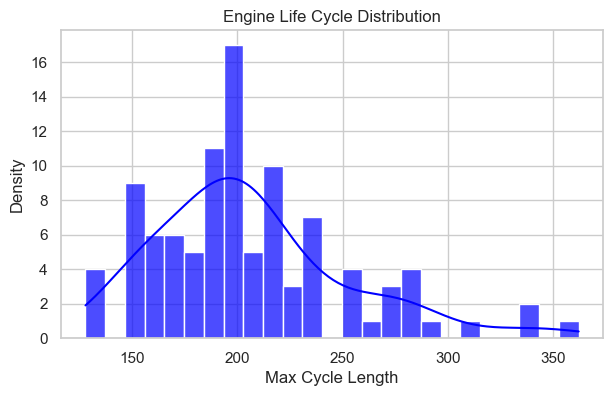

Plotting comparative sensor and settings data for Engine 20...


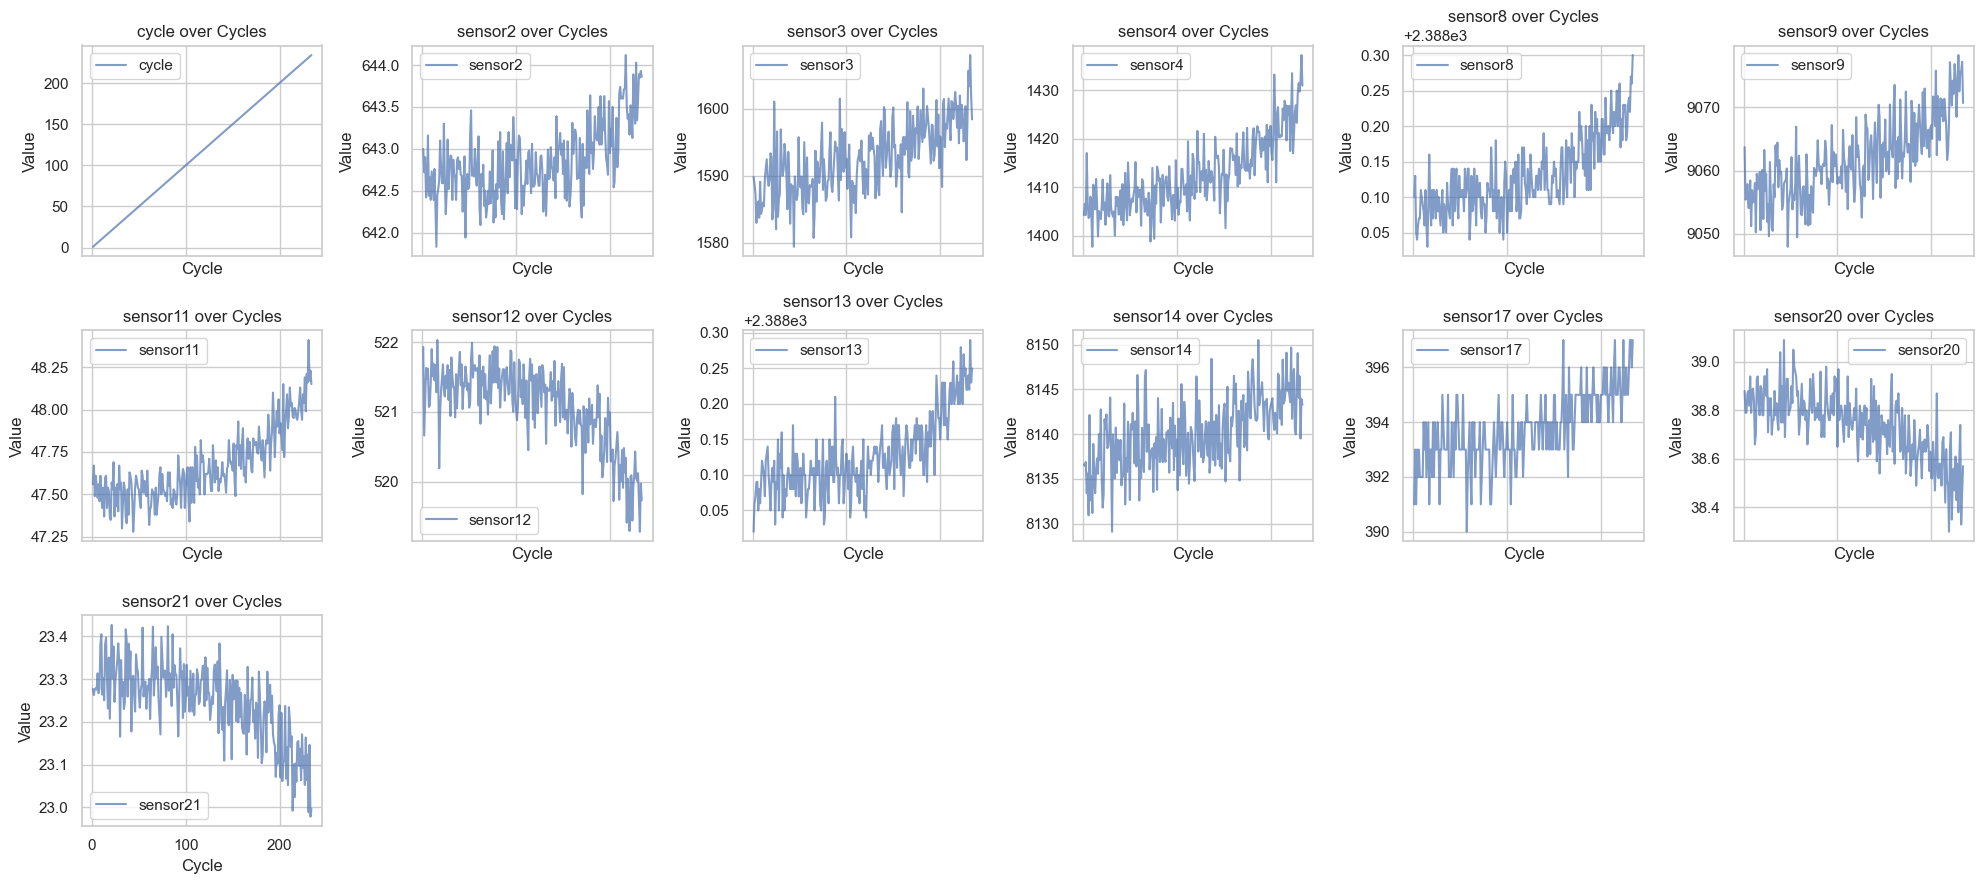

Plotting correlation matrix...


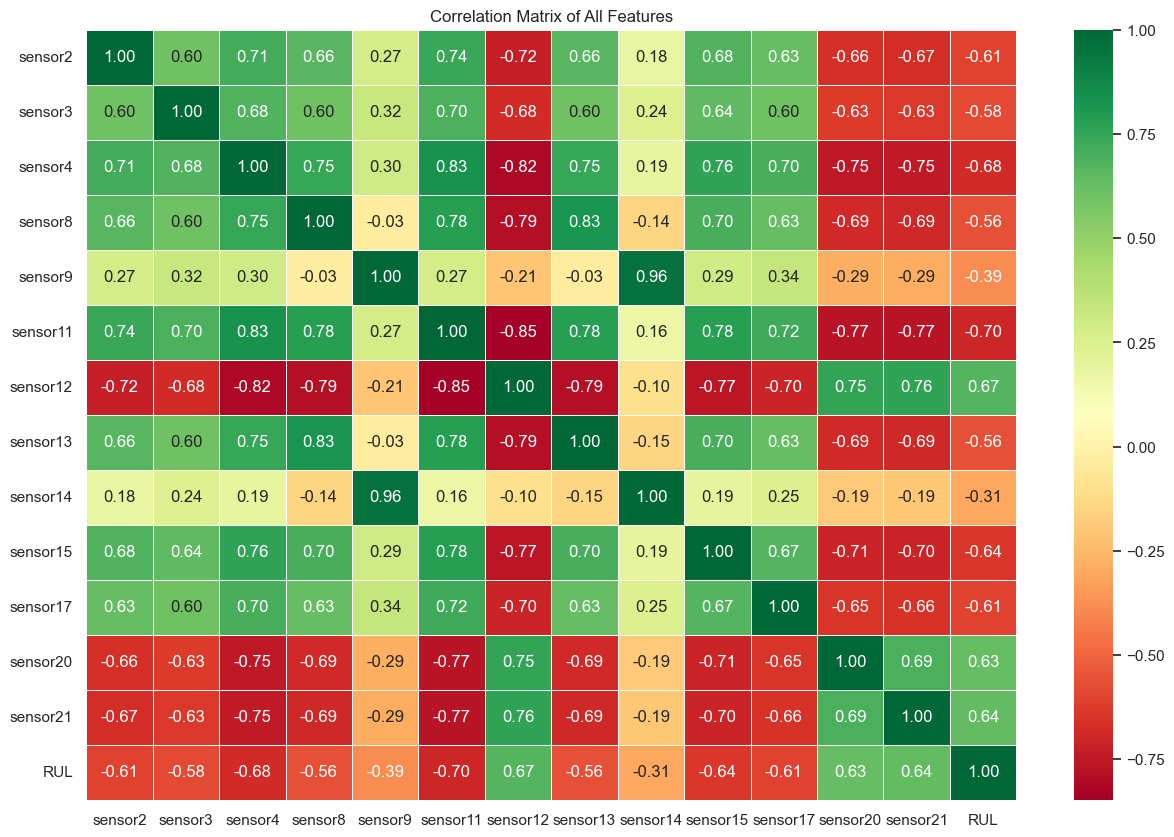


Mean Absolute Correlation with RUL: 0.6125
Standard Deviation of Correlation with RUL: 0.6231


In [2]:
# --- Column Names ---
columns = ["id", "cycle", "op1", "op2", "op3", "sensor1", "sensor2", "sensor3", "sensor4", 
           "sensor5", "sensor6", "sensor7", "sensor8", "sensor9", "sensor10", "sensor11", 
           "sensor12", "sensor13", "sensor14", "sensor15", "sensor16", "sensor17", "sensor18", 
           "sensor19", "sensor20", "sensor21"]

# Load data
train_data = pd.read_csv("train_FD001.txt", sep="\s+", header=None, names=columns)
test_data = pd.read_csv("test_FD001.txt", sep="\s+", header=None, names=columns)
true_rul = pd.read_csv("RUL_FD001.txt", header=None).values.flatten()  # Flatten for 1D array

print(train_data.head())

# Add RUL to training data
train_data['RUL'] = train_data.groupby('id')['cycle'].transform('max') - train_data['cycle']

# Drop unnecessary columns
drop_columns = ['id', 'op1', 'op2', 'op3', 'sensor1', 'sensor5', 'sensor6', 'sensor7', 
                'sensor10', 'sensor16', 'sensor18', 'sensor19']

train_features = train_data.drop(columns=drop_columns + ['RUL'])
test_features = test_data.drop(columns=drop_columns)

# --- Data Preprocessing Functions ---
def drop_low_std(data, threshold=0.05):
    """
    Remove features with standard deviation below the threshold.
    """
    std_dev = data.std()
    low_std_columns = data.columns[std_dev < threshold]
    filtered_data = data.drop(columns=low_std_columns)
    print(f"Columns removed due to low standard deviation: {low_std_columns.tolist()}")
    return filtered_data

def scale_data(train, test):
    """
    Scales numeric features using StandardScaler.
    
    Parameters:
        train (pd.DataFrame): Training features.
        test (pd.DataFrame): Testing features.
        
    Returns:
        tuple: Scaled train and test features as numpy arrays.
    """
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    return train_scaled, test_scaled, scaler

# Remove features with low standard deviation
train_features = drop_low_std(train_features)
test_features = test_features[train_features.columns]  # Ensure test features match training

# Scale training and test data
train_scaled, test_scaled, scaler = scale_data(train_features, test_features)

# --- Align Test Set for Evaluation ---
# Extract the last cycle for each engine in the test set
test_last_cycle = test_data.groupby('id').last().reset_index()
test_last_features = test_last_cycle[train_features.columns]
test_last_scaled = scaler.transform(test_last_features)

# --- Prepare Data for Modeling ---
# Features and labels for training
X_train = train_scaled
y_train = train_data['RUL'].values

# Features and labels for testing
X_test = test_last_scaled
y_test = true_rul

# --- Visualization Functions ---
def max_distribution(data):
    """
    Plot the distribution of maximum engine life cycles.
    """
    max_cycle = data.groupby('id')['cycle'].max()
    plt.figure(figsize=(7, 4))
    sns.histplot(data=max_cycle, kde=True, bins=25, color='blue', alpha=0.7)
    plt.title('Engine Life Cycle Distribution')
    plt.xlabel('Max Cycle Length')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

def comparative_plot(engine_num, data):
    """
    Plot sensor and setting values over cycles for a specified engine.
    """
    engine_data = data[data['id'] == engine_num]
    plot_columns = train_features.columns

    num_columns = 6
    num_rows = (len(plot_columns) + num_columns - 1) // num_columns

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 3), sharex=True)
    axes = axes.flatten()

    for i, column in enumerate(plot_columns):
        ax = axes[i]
        ax.plot(engine_data['cycle'], engine_data[column], label=column, alpha=0.7)
        ax.set_title(f'{column} over Cycles')
        ax.set_xlabel('Cycle')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True)

    # Remove unused axes
    for j in range(len(plot_columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def corr_matrix(data):
    """
    Plot the correlation matrix of all features.
    """
    plt.figure(figsize=(15, 10))
    sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix of All Features')
    plt.grid(False)
    plt.show()
    return data.corr()

# --- Visualizations ---
# 1. Maximum Engine Life Distribution
print("Plotting engine life cycle distribution...")
max_distribution(train_data)

# 2. Comparative Features for a Specific Engine
print("Plotting comparative sensor and settings data for Engine 20...")
comparative_plot(engine_num=20, data=train_data)

# --- Correlation Matrix ---
print("Plotting correlation matrix...")
correlation_matrix = train_data.drop(columns=['id', 'cycle'] + drop_columns).corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of All Features')
plt.grid(False)
plt.show()

# --- Correlation Analysis ---
target_column = 'RUL'  # Define the target column for correlation analysis
excluded_columns = ['id', 'cycle']  # Columns to exclude

# Drop excluded columns dynamically
filtered_corr = correlation_matrix.drop(index=excluded_columns, errors='ignore')

# Dynamically calculate correlation statistics for remaining columns
mean_corr = filtered_corr[target_column].abs().mean()
std_corr = filtered_corr[target_column].std()

print(f"\nMean Absolute Correlation with {target_column}: {mean_corr:.4f}")
print(f"Standard Deviation of Correlation with {target_column}: {std_corr:.4f}")

Linear Regression Testing RMSE: 30.7104
Linear Regression Testing R^2 Score: 0.4538


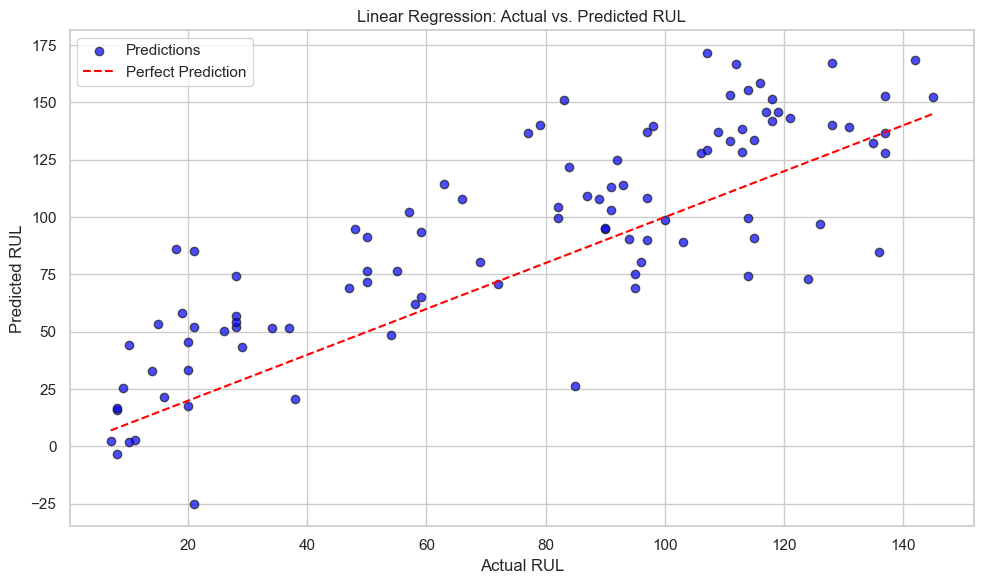


Top Features Driving Predictions:
     Feature  Coefficient
7   sensor12     5.164648
12  sensor21     3.082366
11  sensor20     2.282675
10  sensor17    -1.927591
2    sensor3    -1.956844
8   sensor13    -2.149652
9   sensor14    -2.476184
4    sensor8    -2.763733
1    sensor2    -3.002234
5    sensor9    -4.084102


In [3]:
# --- Linear Regression ---

# --- Step 1: Initialize and Train the Model ---
lr_model = LinearRegression()  # Initialize Linear Regression model
lr_model.fit(X_train, y_train)  # Fit the model on training data

# --- Step 2: Make Predictions ---
y_test_pred = lr_model.predict(X_test)  # Predict RUL for test data

# --- Step 3: Evaluate the Model ---
# Calculate RMSE and R^2 for test set
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)  # Root Mean Squared Error
test_r2 = r2_score(y_test, y_test_pred)  # Coefficient of Determination

# Output evaluation metrics
print(f"Linear Regression Testing RMSE: {test_rmse:.4f}")
print(f"Linear Regression Testing R^2 Score: {test_r2:.4f}")

# --- Step 4: Visualize Actual vs. Predicted RUL ---
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='blue', edgecolor='k', label='Predictions')  # Scatterplot of predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')  # Reference line
plt.title('Linear Regression: Actual vs. Predicted RUL')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 5: Feature Coefficients ---
# Use column names from the original train_features DataFrame
feature_names = train_features.columns  # Retrieve original feature names before scaling

# Create a DataFrame with features and their corresponding coefficients
feature_coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', ascending=False)

# Display the top 10 features
print("\nTop Features Driving Predictions:")
print(feature_coefficients.head(10))

PCA + SVR Testing RMSE: 23.0299
PCA + SVR Testing R^2 Score: 0.6929


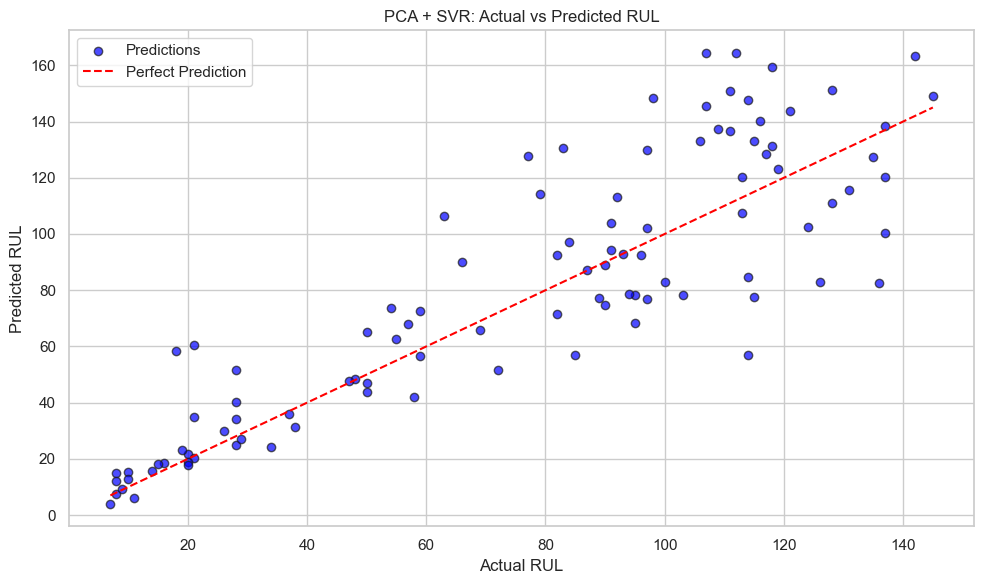

In [4]:
# --- PCA + SVR Model ---

# --- Step 1: Apply PCA to Training and Test Data ---
pca = PCA(n_components=0.95, random_state=0)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train)  # Fit PCA on training data and transform it
X_test_pca = pca.transform(X_test)        # Transform test data using PCA fit on training data

# --- Step 2: Train an SVR Model ---
svr_model = SVR(kernel='rbf', C=10, epsilon=0.1)  # Initialize SVR with RBF kernel
svr_model.fit(X_train_pca, y_train)  # Train the SVR model on PCA-transformed training data

# --- Step 3: Evaluate the Model ---
# Make predictions on the test set
y_test_pred = svr_model.predict(X_test_pca)

# Calculate RMSE and R^2 for the test set
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_r2 = r2_score(y_test, y_test_pred)
# Output evaluation metrics
print(f"PCA + SVR Testing RMSE: {test_rmse:.4f}")
print(f"PCA + SVR Testing R^2 Score: {test_r2:.4f}")

# --- Step 4: Visualize Actual vs. Predicted RUL ---
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='blue', edgecolor='k', label='Predictions')  # Scatterplot of predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')  # Reference line
plt.title('PCA + SVR: Actual vs Predicted RUL')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Random Forest Testing RMSE: 25.8492
Random Forest Testing R^2 Score: 0.6131


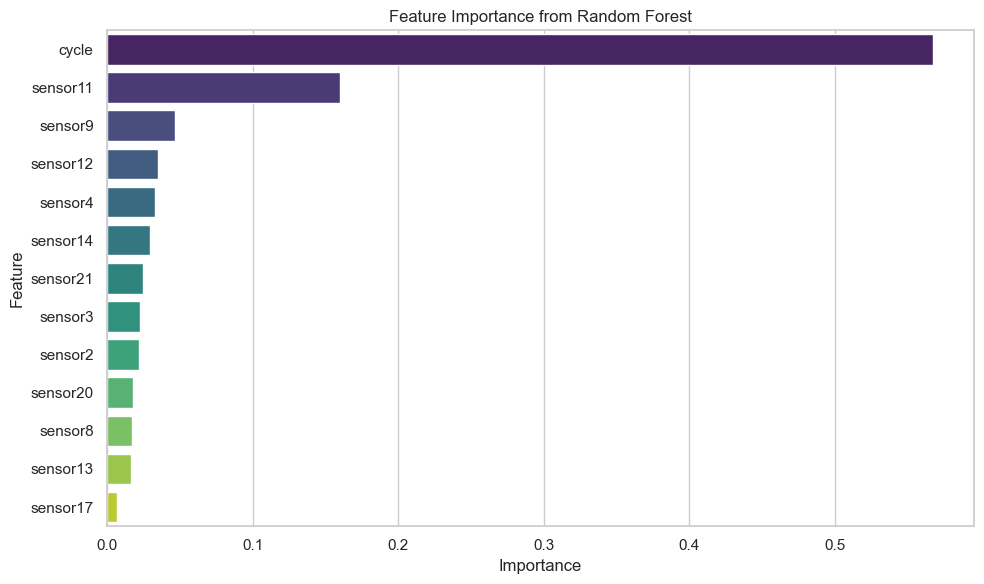

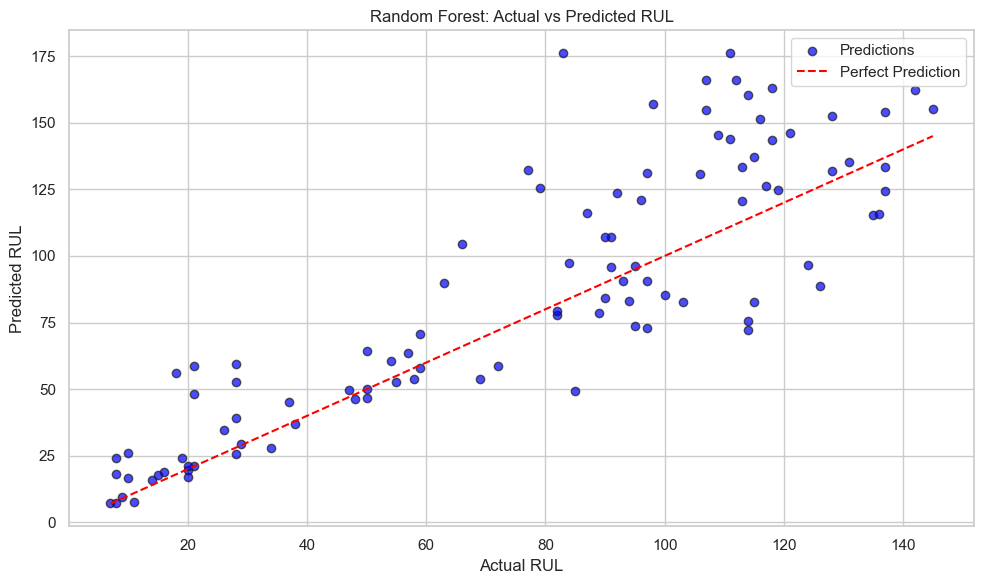

In [5]:
# --- Random Forest Model ---

# --- Step 1: Initialize Random Forest Regressor ---
rf_model = RandomForestRegressor(
    n_estimators=200,       # Number of trees
    max_depth=20,           # Maximum depth of trees
    min_samples_split=5,    # Minimum samples to split an internal node
    min_samples_leaf=2,     # Minimum samples at a leaf node
    random_state=34         # Seed for reproducibility
)

# --- Step 2: Train the Model ---
rf_model.fit(X_train, y_train)  # Train Random Forest on training data

# --- Step 3: Make Predictions on Test Data ---
y_test_pred = rf_model.predict(X_test)  # Predict RUL for test set

# --- Step 4: Evaluate the Model ---
# Calculate RMSE and R^2 on the test set
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_r2 = r2_score(y_test, y_test_pred)

# Print evaluation metrics
print(f"Random Forest Testing RMSE: {test_rmse:.4f}")
print(f"Random Forest Testing R^2 Score: {test_r2:.4f}")

# --- Step 5: Visualize Feature Importance ---
# Extract feature importances from the trained Random Forest model
importances = rf_model.feature_importances_

# Use column names from the original train_features DataFrame
feature_names = train_features.columns  # Retrieve original feature names before scaling

# Create a DataFrame with features and their corresponding importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# --- Step 6: Visualize Actual vs. Predicted RUL ---
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='blue', edgecolor='k', label='Predictions')  # Scatter plot
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')  # Reference line
plt.title('Random Forest: Actual vs Predicted RUL')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 13292.6523 - mae: 95.8085 - val_loss: 14386.7549 - val_mae: 94.2747
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9654.8877 - mae: 78.0786 - val_loss: 11857.7939 - val_mae: 84.1160
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7595.0239 - mae: 68.4305 - val_loss: 10022.3672 - val_mae: 76.7794
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6340.5381 - mae: 62.3326 - val_loss: 8469.0625 - val_mae: 68.1147
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5067.4160 - mae: 52.3747 - val_loss: 7100.7197 - val_mae: 59.9561
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4067.2949 - mae: 45.4599 - val_loss: 6073.4531 - val_mae: 54.9243
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3384.0132 - mae: 41.0731 - val_loss: 5290.5972 - val_mae: 50.8098
Epoch 8/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2880.0332 - mae: 37.2365 - val_loss: 4677.6182 - val_m

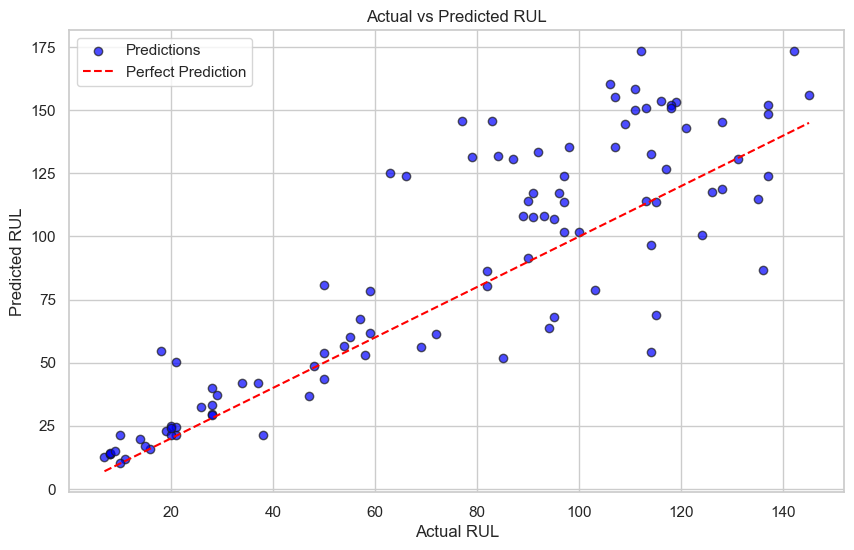

In [6]:
# --- LSTM Model ---

# Load data
columns = ["id", "cycle", "op1", "op2", "op3", "sensor1", "sensor2", "sensor3", "sensor4", 
           "sensor5", "sensor6", "sensor7", "sensor8", "sensor9", "sensor10", "sensor11", 
           "sensor12", "sensor13", "sensor14", "sensor15", "sensor16", "sensor17", "sensor18", 
           "sensor19", "sensor20", "sensor21"]
train_data = pd.read_csv("train_FD001.txt", sep="\s+", header=None, names=columns)
test_data = pd.read_csv("test_FD001.txt", sep="\s+", header=None, names=columns)
true_rul = pd.read_csv("RUL_FD001.txt", header=None).values.flatten()  # Flatten for 1D array

# Add RUL to training data
train_data['RUL'] = train_data.groupby('id')['cycle'].transform('max') - train_data['cycle']

# Drop unnecessary columns
drop_columns = ['id', 'op1', 'op2', 'op3', 'sensor1', 'sensor5', 'sensor6', 'sensor7', 
                'sensor10', 'sensor16', 'sensor18', 'sensor19']
train_features = train_data.drop(columns=drop_columns + ['RUL'])
test_features = test_data.drop(columns=drop_columns)

# Scale data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_features)
test_scaled = scaler.transform(test_features)

# Create sequences for LSTM
def create_sequences(X, y, time_steps):
    n_samples = len(X) - time_steps
    X_seq = np.array([X[i:i + time_steps] for i in range(n_samples)])
    y_seq = y[time_steps:]
    return X_seq, np.array(y_seq)

time_steps = 30
X_seq_train, y_seq_train = create_sequences(train_scaled, train_data['RUL'].values, time_steps)

# Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=input_shape, activation='tanh'),
        Dropout(0.2),  # Regularization
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Define model input shape
input_shape = (X_seq_train.shape[1], X_seq_train.shape[2])
lstm_model = build_lstm_model(input_shape)

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = lstm_model.fit(
    X_seq_train, y_seq_train,
    validation_split=0.2,
    epochs=20,            # Balanced epochs
    batch_size=64,        # Reasonable batch size
    callbacks=[early_stopping],
    verbose=1
)

# Process test data: Create sequences for each engine's last cycles
test_grouped = test_data.groupby('id')
X_seq_test = []
for _, group in test_grouped:
    if len(group) >= time_steps:
        last_window = group.iloc[-time_steps:, :].drop(columns=drop_columns).values
        scaled_window = scaler.transform(last_window)
        X_seq_test.append(scaled_window)

X_seq_test = np.array(X_seq_test)  # Shape: (num_engines, time_steps, num_features)

# Predict RUL for each engine
y_test_pred = lstm_model.predict(X_seq_test).flatten()  # Flatten to 1D array

# Evaluation
test_rmse = np.sqrt(mean_squared_error(true_rul, y_test_pred))
test_r2 = r2_score(true_rul, y_test_pred)
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R2 Score: {test_r2:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(true_rul, y_test_pred, alpha=0.7, color='blue', edgecolor='k', label='Predictions')
plt.plot([true_rul.min(), true_rul.max()],
         [true_rul.min(), true_rul.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted RUL')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.legend()
plt.grid(True)
plt.show()